# Titantic: Machine Learning from Disaster

Following tutorials found here:
- https://www.kaggle.com/pamun9/titanic/titanic-data-science-solutions
- https://www.kaggle.com/helgejo/titanic/an-interactive-data-science-tutorial/run/775411
- https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier


In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Configure visualisations
%matplotlib inline
sns.set_style( 'white' )

# machine learning
from sklearn import cross_validation, preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

train_df = pd.read_csv('./train.csv', header = 0, dtype={'Age': np.float64})
test_df = pd.read_csv('./test.csv', header = 0, dtype={'Age': np.float64})

train_df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [2]:
# describe the data
train_df.describe()

/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Conclusions from Data

*Numerical Fields* - Age, SibSp, Parch, Fare
*Categories* - Survived, Pclass, Sex, Embarked
*Possible Features* - Title, Cabin Letter

- Age has invalid values and will need to be fixed
- Class imbalance of 38%
- Cabin is missing too many data points, throw away

In [4]:
# Helper Functions

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def train_and_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print (model.score( X_test , y_test ))

/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


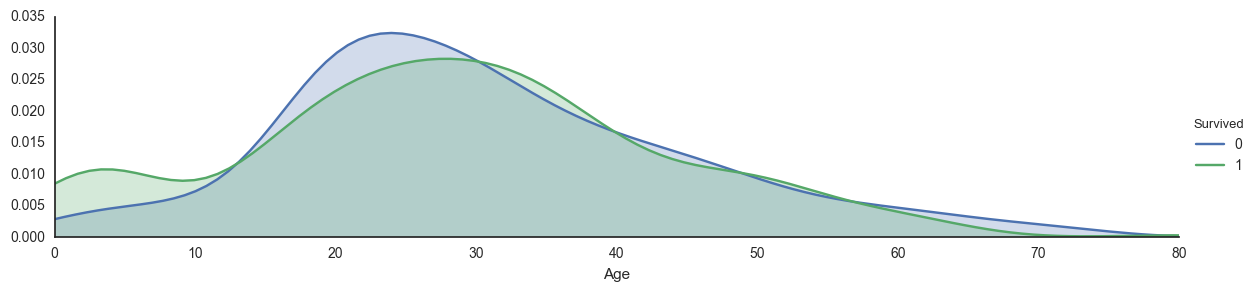

In [5]:
# Age
# corrections need to be made
# train_df['Age'].fillna(train_df['Age'].dropna().mean(), inplace=True)

plot_distribution( train_df , var = 'Age' , target = 'Survived' )

/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


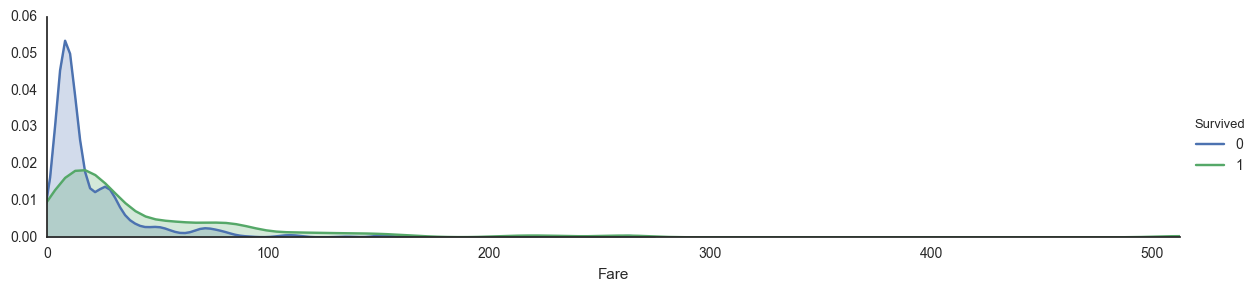

In [6]:
# Fare

plot_distribution( train_df , var = 'Fare' , target = 'Survived' )

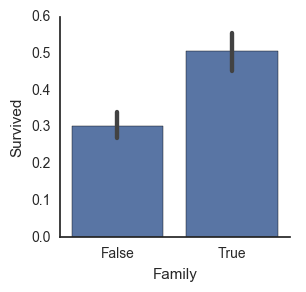

In [7]:
# Family On Board

train_df['Family'] = (train_df.SibSp + train_df.Parch) > 0

plot_categories( train_df , cat = 'Family' , target = 'Survived' )

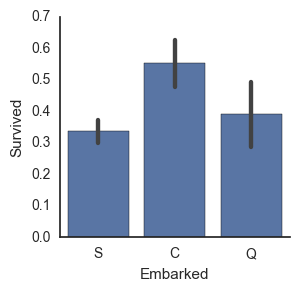

In [8]:
# Embarked From Location

plot_categories( train_df , cat = 'Embarked' , target = 'Survived' )

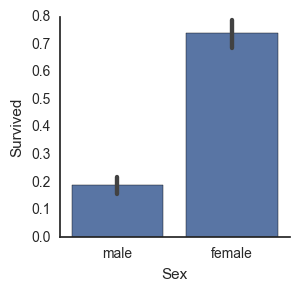

In [9]:
# Sex

plot_categories( train_df , cat = 'Sex' , target = 'Survived' )

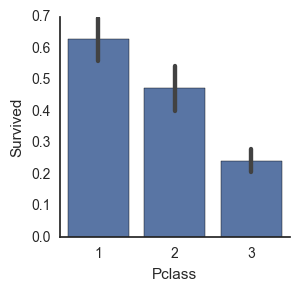

In [10]:
plot_categories( train_df , cat = 'Pclass' , target = 'Survived' )

In [11]:
# Introduce Title

title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = train_df[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


Ready to begin, current features chosen are:
- Female
- Family
- Pclass
- Embarked
- Fare
- Age

In [12]:
# clean training data

female = pd.Series( np.where( train_df.Sex == 'female' , 1 , 0 ) , name = 'Female' )
family = pd.Series( np.where( (train_df.SibSp + train_df.Parch) > 0, 1, 0) , name = 'Family' )
pclass = pd.get_dummies( train_df.Pclass , prefix='Pclass' )
pclass.drop(['Pclass_2'], axis=1, inplace=True)
embarked = pd.get_dummies( train_df.Embarked , prefix='Embarked' )
embarked.drop(['Embarked_Q'], axis=1, inplace=True)
fare = train_df.Fare.fillna(train_df.dropna().mean())

Age is more difficult. Here we need to guess which Age correllates correctly to Pclass and Female, in order to not skew the data

In [13]:
guess_ages = np.zeros((2,3))
guess_ages

train_df['Female'] = female

for dataset in [train_df]:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Female'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Female == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

for dataset in [train_df]:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 1
    dataset.loc[ dataset['Age'] > 10, 'Age'] = 0
    
age = train_df.Age

In [14]:
X = pd.concat( [ female, family, pclass, embarked, title, age ] , axis=1 )
y = train_df.Survived
X.head()

,Female,Family,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Master,Miss,Mr,Mrs,Officer,Royalty,Age
0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,1,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [15]:
# Cross Validation Split

[X_train, X_test, y_train, y_test] = cross_validation.train_test_split(X, y, test_size = 0.10)
X_train.head()

,Female,Family,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Master,Miss,Mr,Mrs,Officer,Royalty,Age
347,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
729,1,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
664,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
251,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
550,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [17]:
# Random Forests
model = RandomForestClassifier(n_estimators=100)
train_and_score(model, X_train, y_train, X_test, y_test)

0.877777777778


In [18]:
# KNN
model = KNeighborsClassifier(n_neighbors = 3)
train_and_score(model, X_train, y_train, X_test, y_test)

0.855555555556


In [16]:
# Logistic Regression
model = LogisticRegression()
train_and_score(model, X_train, y_train, X_test, y_test)

coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

0.811111111111


,Feature,Correlation
0,Female,1.486008
6,Master,1.272975
2,Pclass_1,0.973649
9,Mrs,0.759836
12,Age,0.514606
7,Miss,0.290681
4,Embarked_C,0.216448
5,Embarked_S,-0.325433
1,Family,-0.488250
11,Royalty,-0.494890


In [19]:
# SVM
model = SVC()
train_and_score(model, X_train, y_train, X_test, y_test)

0.8
